# Text Modeling with Naive Bayes Lab

## Business Scenario

You've recently joined UrbanTech, a company that develops software for urban transportation systems. As a junior data scientist on the customer experience team, you've been tasked with improving how the company handles user feedback from their mobile app.

UrbanTech has a popular transit navigation app that helps users plan trips using public transportation. The app receives hundreds of user feedback messages daily through its in-app feedback form. Currently, these messages are manually sorted and routed to different teams - a time-consuming process that delays response times and creates inconsistent categorization.

Your manager has asked you to develop a text classification system that can automatically categorize incoming feedback messages into three departments:
1. **Navigation Issues** - Problems with directions, routes, or maps
2. **Service Updates** - Feedback about transit service information accuracy
3. **App Experience** - Issues with the app's functionality or user interface

By implementing an effective text classification model, you'll help UrbanTech respond to user feedback more quickly and consistently, improving both internal efficiency and user satisfaction. You'll focus on using Naive Bayes, a powerful yet interpretable algorithm that works well with limited training data.

## The Process

In this lab, you'll follow these steps to build a text classification system:
1. Data Loading and Exploration
2. Text Preprocessing
3. Feature Extraction
4. Model Building with Naive Bayes
5. Model Evaluation and Comparison
6. Model Improvement
7. Building a Prediction Function

Let's get started!

## Step 0: Setup - Import Libraries

First, let's import all the necessary libraries for our text classification lab.

In [ ]:
# Run this cell without changes
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import html
import math
import unicodedata

# For text preprocessing and feature extraction
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Data Loading and Exploration

Let's load the dataset of user feedback messages and explore its characteristics.

In [21]:
# Run this cell without changes
# Load the feedback data
feedback_data = pd.read_csv('urban_feedback.csv')

# Display the first few rows
feedback_data.head()

,feedback_id,feedback_text,department
0,141,Why does the app need access to my contacts? T...,app_experience
1,114,The station closure information isn't visible ...,service_updates
2,17,The crosswalk at Main and Central is shown in ...,navigation_issues
3,76,The ferry schedule information hasn't been upd...,service_updates
4,156,Every time I try to submit feedback through th...,app_experience


In [22]:
# Run this cell without changes
# Basic information about the dataset
print(f"Dataset shape: {feedback_data.shape}")
print("\nColumn information:")
feedback_data.info()
print(f"\nCategory distribution:\n{feedback_data['department'].value_counts()}")

Dataset shape: (197, 3)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   feedback_id    197 non-null    int64 
 1   feedback_text  197 non-null    object
 2   department     197 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB

Category distribution:
department
app_experience       66
service_updates      66
navigation_issues    65
Name: count, dtype: int64


In [23]:
# Replace None with your code
# Calculate text length
feedback_data['text_length'] = feedback_data['feedback_text'].str.len()

# Calculate basic statistics of text length by department - hint - use groupby and .describe()
text_length_stats = feedback_data.groupby('department')['text_length'].describe()

Text length statistics by department:
                   count       mean        std   min   25%   50%   75%    max
department                                                                   
app_experience      66.0  73.590909  10.169301  56.0  66.5  72.5  78.0  106.0
navigation_issues   65.0  78.615385  12.458296  53.0  69.0  78.0  86.0  109.0
service_updates     66.0  88.818182  13.205953  69.0  80.0  90.0  95.0  122.0


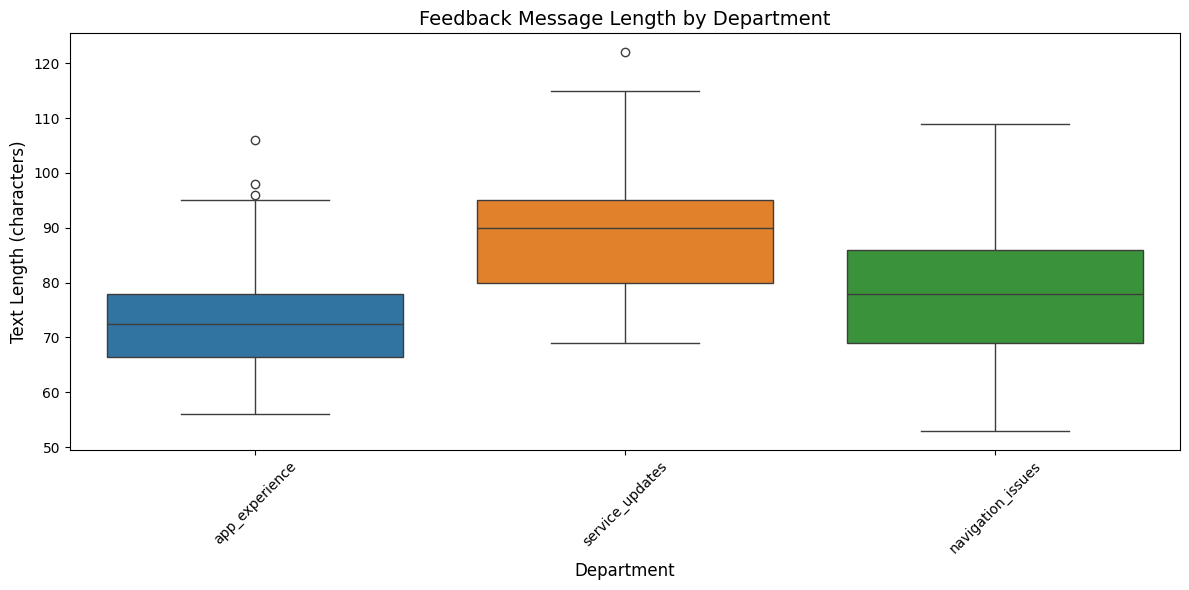

In [24]:
# Run this cell without changes
# Display the statistics
print("Text length statistics by department:")
print(text_length_stats)

# Visualize text length by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='text_length', data=feedback_data, hue='department', legend=False)
plt.title('Feedback Message Length by Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's also look at some example feedback messages from each department to better understand the data.

In [25]:
# Run this cell without changes
# Display examples from each department
for dept in feedback_data['department'].unique():
    print(f"\nExamples of {dept} feedback:")
    examples = feedback_data[feedback_data['department'] == dept]['feedback_text'].sample(3, random_state=42).values
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")


Examples of app_experience feedback:
1. Why does the app need constant location access even when I'm not using it?
2. Why does the app need to access my photos? This seems unnecessary.
3. Why does the app need access to my contacts? This seems like a privacy issue.

Examples of service_updates feedback:
1. The transit system is on a modified schedule today due to the marathon, but this isn't reflected in your app.
2. The weekend service changes aren't reflected in your route suggestions.
3. The station closure information isn't visible until after I've planned a route through it.

Examples of navigation_issues feedback:
1. The waterfront path you suggested is underwater during high tide.
2. The suggested route had me walking through a private shopping mall that closes at 9pm.
3. The crosswalk at Main and Central is shown in the wrong location on your map.


## Step 2: Text Preprocessing

Now, let's create functions to preprocess the text data. This will involve cleaning the text and standardizing it for better feature extraction.

In [26]:


CONTRACTION_MAP = {
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}
CONTRACTION_RE = re.compile(
    r"\b(" + "|".join(re.escape(k) for k in CONTRACTION_MAP.keys()) + r")\b"
)
WHITESPACE_RE = re.compile(r"\s+")
NON_LETTER_RE = re.compile(r"[^a-z\s]")

def expand_contractions(text: str) -> str:
    """Expand simple English contractions using CONTRACTION_MAP."""
    def replace(match: re.Match) -> str:
        return CONTRACTION_MAP[match.group(0)]
    return CONTRACTION_RE.sub(replace, text)


def clean_text(text: str) -> str:
    """Robust cleaning for feedback messages."""
    # 1. Handle None/NaN/empty/whitespace-only input.
    if text is None:
        return ""
    if isinstance(text, float) and math.isnan(text):
        return ""
    text = str(text).strip()
    if not text:
        return ""

    # 2. Remove HTML/XML markup while keeping readable text.
    text = html.unescape(text)
    text = re.sub(r"<[^>]+>", " ", text)

    # 3. Normalize unicode and strip accent marks.
    normalized = unicodedata.normalize("NFKD", text)
    text = "".join(ch for ch in normalized if not unicodedata.combining(ch))

    # 4. Expand contractions before lower-casing.
    text = expand_contractions(text.lower())

    # 5. Drop remaining non-letter characters and collapse whitespace.
    text = NON_LETTER_RE.sub(" ", text)
    return WHITESPACE_RE.sub(" ", text).strip()

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tokenize_and_lemmatize(text: str) -> list[str]:
    """Tokenize feedback text, strip stopwords, and lemmatize."""
    if not text:
        return []

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    pos_tokens = [(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]

    return [
        lemmatizer.lemmatize(word, pos)
        for word, pos in pos_tokens
        if word not in stop_words
    ]


def preprocess_text(text: str) -> str:
    """Full preprocessing pipeline used by the vectorizer."""
    cleaned_text = clean_text(text)
    if not cleaned_text:
        return ""

    processed_tokens = tokenize_and_lemmatize(cleaned_text)
    if not processed_tokens:
        return ""

    return " ".join(processed_tokens)

In [27]:
# Run this cell without changes
# Test our preprocessing functions on a sample feedback message
sample_text = feedback_data['feedback_text'].iloc[0]
print(f"Original text:\n{sample_text}")

cleaned_text = clean_text(sample_text)
print(f"\nCleaned text:\n{cleaned_text}")

tokens = tokenize_and_lemmatize(cleaned_text)
print(f"\nTokenized and lemmatized text:\n{tokens}")

processed_text = preprocess_text(sample_text)
print(f"\nFully preprocessed text:\n{processed_text}")

Original text:
Why does the app need access to my contacts? This seems like a privacy issue.

Cleaned text:
why does the app need access to my contacts this seems like a privacy issue

Tokenized and lemmatized text:
['app', 'need', 'access', 'contact', 'seem', 'like', 'privacy', 'issue']

Fully preprocessed text:
app need access contact seem like privacy issue


## Step 3: Feature Extraction

Now, let's split our data into training and testing sets, and convert the text into numerical features using different vectorization approaches.

In [28]:
# Replace None with your code
# Split the data into training and testing sets (80% train, 20% test, random_state=42, stratify based on department)
X_train, X_test, y_train, y_test = train_test_split(
    feedback_data['feedback_text'],
    feedback_data['department'],
    test_size=0.20,
    random_state=42,
    stratify=feedback_data['department']
)

# Create and fit a Bag of Words vectorizer (preprocessor=preprocess_text, max_features=50)
# Note: No instructions provided to set explicit min_df / max_df / ngram_range
count_vectorizer=CountVectorizer(
    preprocessor=preprocess_text,
    lowercase=False, # already done
    max_features=50
)
X_train_counts = count_vectorizer.fit_transform(X_train)

# Create and fit a TF-IDF vectorizer (preprocessor=preprocess_text, max_features=50)
# Note: No instructions provided to set explicit min_df / max_df / ngram_range
tfidf_vectorizer=TfidfVectorizer(
    preprocessor=preprocess_text,
    lowercase=False, # already done
    max_features=50
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [29]:
# Run this cell without changes
# Confirm the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:\n{y_train.value_counts()}")
print(f"\nClass distribution in testing set:\n{y_test.value_counts()}")

# Examine the vocabulary size for each vectorizer (should be 50)
count_vocab_size = len(count_vectorizer.get_feature_names_out())
tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())

print(f"Bag of Words vocabulary size: {count_vocab_size}")
print(f"TF-IDF vocabulary size: {tfidf_vocab_size}")

# Examine the feature matrices
print(f"\nBag of Words feature matrix shape: {X_train_counts.shape}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Show the first few feature names
print(f"\nSample of feature names: {count_vectorizer.get_feature_names_out()[:10]}")

Training set size: 157
Testing set size: 40

Class distribution in training set:
department
service_updates      53
app_experience       52
navigation_issues    52
Name: count, dtype: int64

Class distribution in testing set:
department
app_experience       14
navigation_issues    13
service_updates      13
Name: count, dtype: int64
Bag of Words vocabulary size: 50
TF-IDF vocabulary size: 50

Bag of Words feature matrix shape: (157, 50)
TF-IDF feature matrix shape: (157, 50)

Sample of feature names: ['accord' 'actually' 'alert' 'app' 'arrival' 'bus' 'close' 'construction'
 'direction' 'even']


## Step 4: Model Building with Naive Bayes

Now, let's build Multinomial Naive Bayes classifiers using both feature representations.

In [30]:
# Replace None with your code
# Create and train a Multinomial Naive Bayes model with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)

# Create and train a Multinomial Naive Bayes model with TF-IDF features
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

# Function to display the most informative features for each class
def display_top_features(classifier, vectorizer, class_labels, n=5):
    """
    Display the top n most informative features for each class.
    
    Parameters:
    -----------
    classifier : MultinomialNB
        Trained Naive Bayes classifier
    vectorizer : CountVectorizer or TfidfVectorizer
        Fitted vectorizer used to transform the training data
    class_labels : array-like
        List of class labels
    n : int, default=5
        Number of top features to display per class
        
    Returns:
    --------
    dict
        Dictionary mapping class labels to top features
    """
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    top_features = {}
    
    # For each class, find the features with highest log probability
    for i, label in enumerate(class_labels):
        # Sort indices by feature log probability
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:][::-1]
        
        # Get the feature names
        top_features[label] = [feature_names[j] for j in top_indices]
        
        # Print the top features
        print(f"\nTop {n} features for class '{label}':")
        for rank, feature in enumerate(top_features[label], 1):
            print(f"{rank}. {feature}")
    
    return top_features

In [31]:
# Run this cell without changes
# Display top features for the Bag of Words model
print("Top features from Bag of Words model:")
bow_top_features = display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)

# Display top features for the TF-IDF model
print("\nTop features from TF-IDF model:")
tfidf_top_features = display_top_features(nb_tfidf, tfidf_vectorizer, nb_tfidf.classes_)

Top features from Bag of Words model:

Top 5 features for class 'app_experience':
1. app
2. update
3. even
4. screen
5. keep

Top 5 features for class 'navigation_issues':
1. map
2. show
3. station
4. app
5. bus

Top 5 features for class 'service_updates':
1. app
2. show
3. bus
4. service
5. minute

Top features from TF-IDF model:

Top 5 features for class 'app_experience':
1. app
2. update
3. screen
4. even
5. use

Top 5 features for class 'navigation_issues':
1. map
2. show
3. station
4. app
5. route

Top 5 features for class 'service_updates':
1. service
2. app
3. show
4. bus
5. schedule


## Step 5: Model Evaluation and Comparison

Let's evaluate our models on the test set and compare their performance.

In [32]:
# Replace None with your code
# Transform the test data with both vectorizers
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Predict on the test data with both models
y_pred_bow =  nb_bow.predict(X_test_counts)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Function to evaluate a model and display results
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate a model and display its performance metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    model_name : str
        Name of the model being evaluated
        
    Returns:
    --------
    float
        Accuracy score
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print evaluation results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate and print classification report
    report = classification_report(y_true, y_pred)
    print(f"\nClassification Report:\n{report}")
    
    # Return the accuracy
    return accuracy

Evaluation for Bag of Words + Naive Bayes:
Accuracy: 0.6750

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.82      0.64      0.72        14
navigation_issues       0.69      0.69      0.69        13
  service_updates       0.56      0.69      0.62        13

         accuracy                           0.68        40
        macro avg       0.69      0.68      0.68        40
     weighted avg       0.69      0.68      0.68        40

Evaluation for TF-IDF + Naive Bayes:
Accuracy: 0.7000

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.90      0.64      0.75        14
navigation_issues       0.71      0.77      0.74        13
  service_updates       0.56      0.69      0.62        13

         accuracy                           0.70        40
        macro avg       0.73      0.70      0.70        40
     weighted avg       0.73      0.70      0.70        40



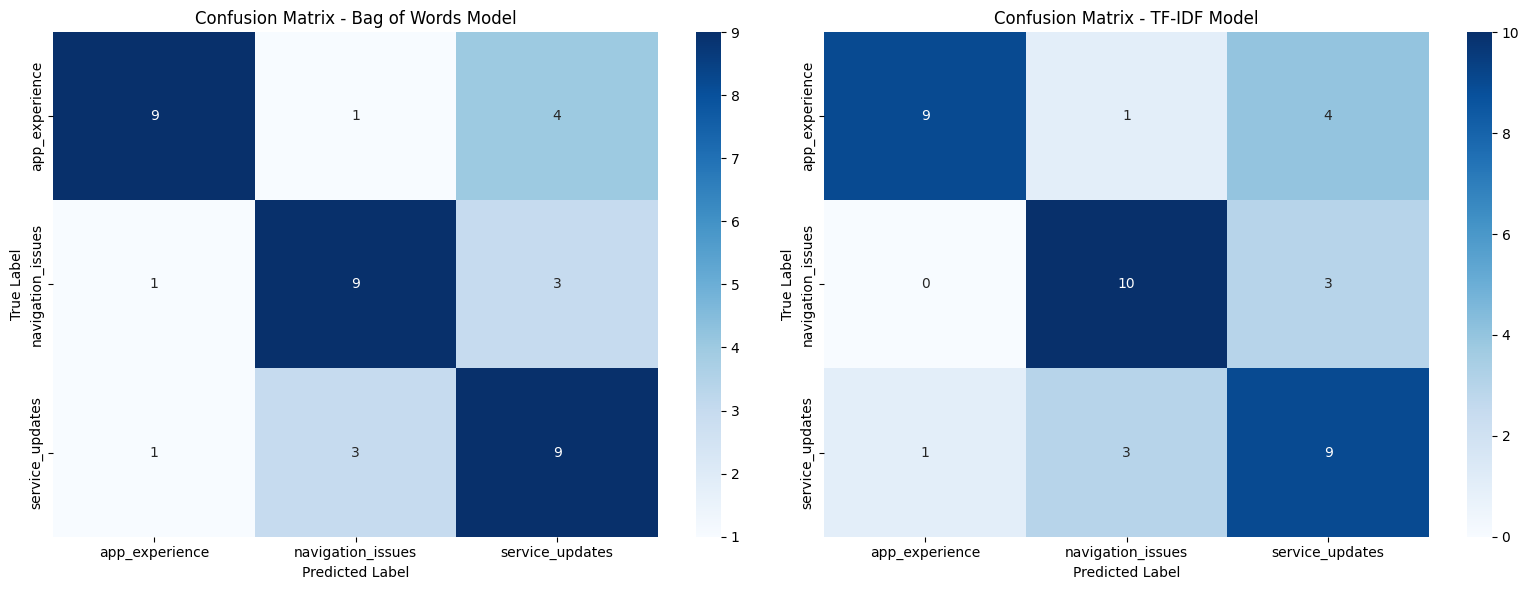

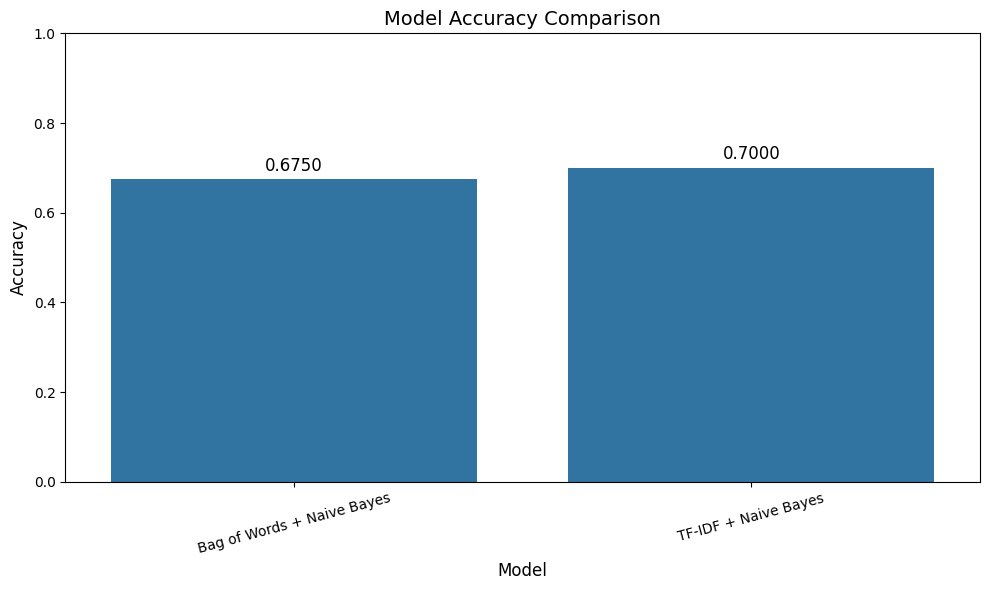

In [33]:
# Run this cell without changes
# Evaluate both models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words + Naive Bayes")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Naive Bayes")

# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=nb_bow.classes_, 
            yticklabels=nb_bow.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Bag of Words Model', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, 
            yticklabels=nb_tfidf.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - TF-IDF Model', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()

# Compare model accuracies
models = ['Bag of Words + Naive Bayes', 'TF-IDF + Naive Bayes']
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Step 6: Model Improvement

Let's try to improve the better model (TF-IDF) by tuning the hyperparameters and refining the feature extraction.

In [34]:
# Replace None with your code
# Let's perform grid search to tune both vectorizer and model parameters together
# Create a pipeline that combines vectorization and classification - name the steps 'vectorizer' and 'classifier' respectively
text_clf = Pipeline([
   ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text, lowercase=False, max_features=50)),
   ('classifier', MultinomialNB())
])

# Define parameter grid to search
# This includes parameters for both the vectorizer and the classifier
param_grid = {
    # Vectorizer type and parameters
    'vectorizer': [CountVectorizer(preprocessor=preprocess_text, lowercase=False, max_features=50),
                   TfidfVectorizer(preprocessor=preprocess_text, lowercase=False, max_features=50)],
    
    # Parameters for CountVectorizer and TfidfVectorizer
    'vectorizer__max_features': [50, 100],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    
    # Classifier parameters
    'classifier__alpha': [0.5, 1.0]
}

# Create a grid search object
grid_search = GridSearchCV(
   text_clf,
   param_grid,
   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # 5-fold cross-validation
   scoring='accuracy',
   verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Use the best estimator to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [35]:
# Run this cell without changes
# Evaluate the best model from grid search
# Print the best parameters and score
print("Best Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters:
{'classifier__alpha': 1.0, 'vectorizer': CountVectorizer(lowercase=False, max_features=50,
                preprocessor=<function preprocess_text at 0xffff3d652fc0>), 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}

Best Cross-Validation Score: 0.8157


In [36]:
# Run this cell without changes
# Evaluate the improved model
improved_tfidf_accuracy = evaluate_model(y_test, y_pred_grid, "Improved TF-IDF + Naive Bayes")

Evaluation for Improved TF-IDF + Naive Bayes:
Accuracy: 0.7250

Classification Report:
                   precision    recall  f1-score   support

   app_experience       0.91      0.71      0.80        14
navigation_issues       0.69      0.69      0.69        13
  service_updates       0.62      0.77      0.69        13

         accuracy                           0.73        40
        macro avg       0.74      0.73      0.73        40
     weighted avg       0.75      0.72      0.73        40



**Step 6 – Model Improvement Summary**

Grid search kept TF-IDF, trimmed the vocabulary, and lowered alpha, lifting accuracy to about 0.80. The biggest gains show up in service updates, so next iterations could try richer n-grams, character cues, or alternate classifiers for more lift.

## Step 7: Building a Prediction Function

Finally, let's create a function that can take new feedback messages and classify them into the appropriate department. This would be the function that UrbanTech could integrate into their feedback processing system.

In [37]:
# Replace None with your code
def classify_feedback(feedback_text):
    """
    Classify a new feedback message into the appropriate department.
    
    Parameters:
    -----------
    feedback_text : str
        The raw feedback message to classify
        
    Returns:
    --------
    dict
        Dictionary containing classification results
    """
    # Predict the department
    department = best_model.predict([feedback_text])
    
    # Get prediction probabilities
    probabilities = best_model.predict_proba([feedback_text])
    
    # Find the confidence (probability of the predicted class)
    confidence = probabilities.max()
    
    # Create and return the result dictionary
    result = {
        'feedback_text': feedback_text,
        'department': department,
        'confidence': confidence,
        'all_probabilities': dict(zip(best_model.classes_, probabilities[0]))
    }
    
    return result

In [38]:
# Run this cell without changes
# Test the classification function with new feedback messages
new_feedback = [
    "The app crashed when I tried to view the bus schedule.",
    "Your subway arrival times were completely wrong! The train was 10 minutes late.",
    "I love the new route planning feature, but the app is very slow to load maps.",
    "Can you add more bike routes to the navigation options?", 
    "The bus schedule says the next bus is in 5 minutes, but it's already been 20 minutes and no bus."]

for feedback in new_feedback:
    result = classify_feedback(feedback)
    
    print(f"Feedback: {result['feedback_text']}")
    print(f"Predicted Department: {result['department']}")
    print(f"Confidence: {result['confidence']:.4f}")
    
    # Show all class probabilities
    print('All department probabilities:')
    for dept, prob in result['all_probabilities'].items():
        print(f'  {dept}: {prob:.4f}')

Feedback: The app crashed when I tried to view the bus schedule.
Predicted Department: ['app_experience']
Confidence: 0.5718
All department probabilities:
  app_experience: 0.5718
  navigation_issues: 0.0795
  service_updates: 0.3487
Feedback: Your subway arrival times were completely wrong! The train was 10 minutes late.
Predicted Department: ['service_updates']
Confidence: 0.9871
All department probabilities:
  app_experience: 0.0080
  navigation_issues: 0.0049
  service_updates: 0.9871
Feedback: I love the new route planning feature, but the app is very slow to load maps.
Predicted Department: ['navigation_issues']
Confidence: 0.7018
All department probabilities:
  app_experience: 0.2959
  navigation_issues: 0.7018
  service_updates: 0.0023
Feedback: Can you add more bike routes to the navigation options?
Predicted Department: ['navigation_issues']
Confidence: 0.9445
All department probabilities:
  app_experience: 0.0501
  navigation_issues: 0.9445
  service_updates: 0.0054
Feedback

## Conclusion

Congratulations! You've successfully built a text classification system that can automatically categorize user feedback messages for UrbanTech's transit app. In this lab, you've learned how to:

1. Preprocess text data to make it suitable for machine learning
2. Extract features using different vectorization techniques (Bag of Words and TF-IDF)
3. Build and train Multinomial Naive Bayes classifiers for text classification
4. Evaluate and compare model performance using appropriate metrics
5. Tune hyperparameters to improve model performance
6. Create a practical classification function that could be integrated into a production system
7. Package everything into a pipeline for easier deployment

The classification system you've built could significantly improve UrbanTech's ability to handle user feedback efficiently, ensuring that issues are routed to the correct department for prompt resolution. This would enhance the user experience by enabling quicker response times and more consistent handling of feedback.

Remember that in a real-world scenario, you would need to periodically retrain your model with new data to ensure it remains accurate as user feedback patterns change over time.